# [Phystech@DataScience](https://thetahat.ru/courses/ph-ds-2025-spr)

# Семинар. Регуляризация на реальных данных

В этом ноутбуке мы увидим, как регуляризация помогает бороться с мультиколлинеарностью на реальных данных [Всемирного Банка](https://data.worldbank.org/).

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", font_scale=1.4, palette="Set2")

import warnings

warnings.simplefilter(action="ignore")

random_state = 42



---



## Введение

[Данные Всемирного Банка](https://data.worldbank.org/) &mdash; это обширная библиотека, в которой собирается многолетняя статистика различных данных со всего мира.

А именно, нас интересует датасет [World Development Indicators](https://datacatalog.worldbank.org/search/dataset/0037712). Это &mdash; многомерная таблица, которая включает в себя разнообразные показатели (индикаторы), собранные по различным странам за определенные года. Они охватывают широкий спектр областей, включая экономики стран, демографию, социальное развитие, образование, экологию и многое другое. Вот список лишь некоторых из них:

*   **Охват начальным образованием** (`Adjusted net enrollment rate, primary (% of primary school age children)`)
 &mdash; процент детей школьного возраста, посещающих начальную или среднюю школу.
*   **Индекс качества кредитной осведомлённости**`(Depth of credit information index (0=low to 8=high))`– показывает уровень доступности информации о кредитах для населения. Высокий индекс означает, что граждане имеют больше информации для принятия решений о кредитовании.
*   **Экспорт или импорт товаров и услуг** – множество показателей, отражающих торговые потоки между странами в различных единицах измерения.
*   **Валовой внутренний/национальный продукт** ([`GDP`](https://en.wikipedia.org/wiki/Gross_domestic_product), [`GNI`](https://en.wikipedia.org/wiki/Gross_national_income#Gross_national_product)) – широкий спектр индикаторов, оценивающих экономическую активность стран в различных нормировках и метриках (например, ВВП [на душу населения](https://en.wikipedia.org/wiki/Gross_domestic_product#GDP_per_capita) и [по паритету покупательской способности](https://en.wikipedia.org/wiki/Purchasing_power_parity)).
*   **Площадь лесов**   (`forest area`) – площадь земли, покрытая деревьями (исключая сельскохозяйственные насаждения, городские парки).
*   **Индекс человеческого капитала** ([`Human capital index (HCI) (scale 0-1)`](https://datacatalog.worldbank.org/indicator/b23f8196-bece-eb11-bacc-000d3a3b9510/Human-capital-index--HCI---scale-0-1-)) – показывает вклад здоровья и образования в производительность труда. Он учитывает долю новорожденных, которые к моменту выхода на рынок труда будут здоровы и образованны. Значения индекса находятся в диапазоне от 0 до 1.
*   **Уровень грамотности** (`Literacy rate`) – показатели грамотности среди взрослых и детей, с разделением по полу.
*   **Процент доучившихся до выпускного класса начальной школы** (`Persistence to last grade of primary, total (% of cohort)`) – доля детей, окончивших начальную школу, от общего числа поступивших в первый класс.
*   **Показатели, связанные с уровнем безработицы** (`Unemployment...`) – различные индикаторы безработицы с разделением по полу и уровню образования.


Каждая строка в этой таблице представляет собой набор данных для определенной страны (или региона) и конкретного показателя за разные годы. Выглядит это следующим образом:

| Полное название страны | Код страны | Полное наименование индикатора | Код индикатора | Значения индикатора за 1960 год | ... за 1961 | ... | ... за 2023 |
|------------------------|------------|--------------------------------|----------------|---------------------------------|------------|-----|-------------|

Для каждой страны представлено около $1500$ индикаторов. Всего в таблице более $250$ стран.

Итого: $1500 \cdot 250 \sim $ немногим меньше $400$ $000$ строк.

## Смотрим на данные
Скачаем архив `CSV` и посмотрим на основной файл с данными:

In [ ]:
df = pd.read_csv("WDICSV.csv")
print(f"Размер таблицы: {df.shape}")
df.head(3)

Размер таблицы: (397936, 68)


Country Name Country Code  \
0  Africa Eastern and Southern          AFE   
1  Africa Eastern and Southern          AFE   
2  Africa Eastern and Southern          AFE   

                                      Indicator Name     Indicator Code  1960  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   NaN   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.RU.ZS   NaN   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.UR.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2014       2015       2016  \
0   NaN   NaN   NaN   NaN   NaN  ...  17.401410  17.911234  18.463874   
1   NaN   NaN   NaN   NaN   NaN  ...   6.728819   7.005877   7.308571   
2   NaN   NaN   NaN   NaN   NaN  ...  38.080931  38.422282  38.722108   

        2017       2018       2019       2020       2021       2022  2023  
0  18.924037  19.437054  20.026254  20.647969  21.165877  21.863139   NaN  
1   7.547226   7.875917   8.243018   8.545483   8.906711   9.261320   NaN  
2  38.993157  39.337872  39.695279  40.137847  40.522209  41.011132   NaN  

[3 rows x 68 columns]

Кодовые имена для стран и индикаторов представлены для краткости записи. Будем пользоваться ими, а чтобы быстро сопоставлять им полные названия, сохраним эти взаимные соответсвия в отдельные переменные.

In [4]:
countries = pd.Series(
    df["Country Name"].values, index=df["Country Code"], name="Country Name"
)
countries = countries[~countries.index.duplicated(keep="first")]
countries.head(3)

Country Code
AFE    Africa Eastern and Southern
AFW     Africa Western and Central
ARB                     Arab World
Name: Country Name, dtype: object

In [5]:
indicators = pd.Series(
    df["Indicator Name"].values, index=df["Indicator Code"], name="Indicator Name"
)
indicators = indicators[~indicators.index.duplicated(keep="first")]
indicators.sample(3, random_state=random_state)

Indicator Code
DT.NFL.UNTA.CD       Net official flows from UN agencies, UNTA (cur...
GC.TAX.TOTL.GD.ZS                               Tax revenue (% of GDP)
SP.POP.65UP.TO.ZS    Population ages 65 and above (% of total popul...
Name: Indicator Name, dtype: object

Убедимся в том, что данные соответствуют приведённому описанию. Для этого сгруппируем их по странам и посчитаем количество записей по столбцам:

In [6]:
df_groupped = df.groupby("Country Name").count()
df_groupped.sample(7, random_state=random_state)

Country Code  Indicator Name  Indicator Code  1960  \
Country Name                                                                   
Northern Mariana Islands          1496            1496            1496    83   
Jamaica                           1496            1496            1496   181   
Liberia                           1496            1496            1496   125   
Small states                      1496            1496            1496   117   
Chile                             1496            1496            1496   261   
Uzbekistan                        1496            1496            1496    86   
Luxembourg                        1496            1496            1496   135   

                          1961  1962  1963  1964  1965  1966  ...  2014  2015  \
Country Name                                                  ...               
Northern Mariana Islands    86    86    86    86    89    86  ...   191   201   
Jamaica                    203   217   221   212   220   232  ...  1052  1030   
Liberia                    151   156   160   155   161   161  ...   923   780   
Small states               127   129   128   129   133   130  ...   766   771   
Chile                      285   307   314   309   318   317  ...  1072  1150   
Uzbekistan                  89    89    89    89    91    89  ...  1027  1030   
Luxembourg                 133   136   135   135   139   144  ...  1034  1034   

                          2016  2017  2018  2019  2020  2021  2022  2023  
Country Name                                                              
Northern Mariana Islands   189   189   190   190   180   130   104    75  
Jamaica                   1076  1057  1076   991   863   806   680   355  
Liberia                    903   886   753   749   763   673   573   197  
Small states               753   746   756   725   654   605   524   303  
Chile                     1074  1133   996   987   970   862   766   423  
Uzbekistan                1008  1024  1034  1028   986   930   759   416  
Luxembourg                1009  1004   971   975   954   857   721   369  

[7 rows x 67 columns]

Действительно, каждая страна формально представлена 1496 строками в таблице. Составители организовали таблицу так, чтобы набор индикаторов был одинаков для всех. Однако, судя по конкретным годовым статистикам, по многим показателям есть пропущенные значения, и мало где число записей достигает хотя бы 1000.

Причины этого ясны: в каких-то регионах планеты сложнее собирать данные, в каких-то легче. Более того, прослеживается эволюция этого датасета. Очевидно, что с развитием цивилизации появлялась необходимость (и возможность) собирать больше данных. Как следствие, придумывались и добавлялись новые индикаторы, по которым до этого учёт не вёлся.

Нельзя не отметить также спад числа записей, начавшийся приблизительно в 2019-2021 годах. В этом можно заподозрить пандемию COVID19.

Поскольку человеческому глазу приятнее видеть цветовую палитру, нежели голые числа, преобразуем таблицу в картинку и взглянем на неё целиком. Для этого можно воспользоваться функцией [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) библиотеки *seaborn*.

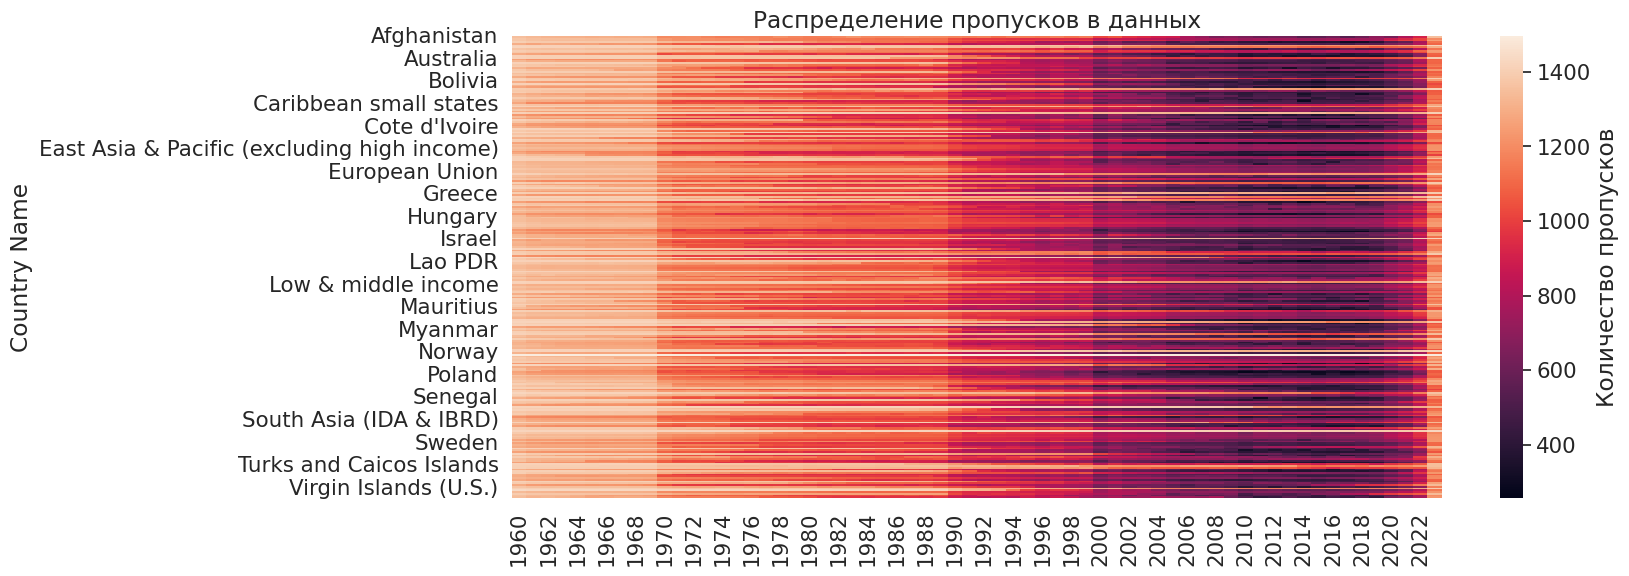

In [7]:
plt.figure(figsize=(15, 6))

# Обычно смотрят не на количество записей, а на количество пропущенных ячеек
sns.heatmap(
    len(df["Indicator Name"].unique()) - df_groupped.iloc[:, 3:],
    cbar_kws={"label": "Количество пропусков"},
)
plt.title("Распределение пропусков в данных");

Видно, что сделанные выводы распространяются практически на всю таблицу.

С таким большим датасетом работать довольно сложно. Естесственным является желание рассмотреть распределение всех индикаторов по странам за некоторый конкретный год. Оставим 2022 год, выделив индикаторы в столбцы, а страны расположим в строках.

Результат будет такой:

In [8]:
df22 = df.pivot_table(
    index="Country Code", columns="Indicator Code", values="2022", aggfunc="first"
)
df22.sample(5, random_state=random_state)

Indicator Code  AG.LND.CREL.HA  AG.PRD.CREL.MT  AG.PRD.CROP.XD  \
Country Code                                                     
NZL                   113518.0       967398.93          108.20   
ITA                  3010620.0     14300570.00           93.95   
HKG                        0.0            0.06          101.49   
BIH                   207036.0      1431169.00          128.06   
ARG                 18063791.0     91584182.57          107.33   

Indicator Code  AG.PRD.FOOD.XD  AG.PRD.LVSK.XD  AG.YLD.CREL.KG  \
Country Code                                                     
NZL                     100.57           99.00          8522.0   
ITA                      96.97          102.34          4750.0   
HKG                     141.66          149.97          2079.6   
BIH                     113.39           83.81          6912.7   
ARG                     109.39          113.91          5070.0   

Indicator Code  BG.GSR.NFSV.GD.ZS  BM.GSR.CMCP.ZS  BM.GSR.FCTY.CD  \
Country Code                                                        
NZL                     11.645655       45.100731    1.409778e+10   
ITA                     12.904907       44.904146    8.588524e+10   
HKG                     40.787834       45.344914    2.071293e+11   
BIH                     15.812834       19.064109    1.058158e+09   
ARG                      5.648610       39.767467    1.540821e+10   

Indicator Code  BM.GSR.GNFS.CD  ...    VA.EST  VA.NO.SRC  VA.PER.RNK  \
Country Code                    ...                                    
NZL               7.134960e+10  ...  1.639671       10.0   99.516907   
ITA               7.855490e+11  ...  1.070306       10.0   82.608696   
HKG               6.828809e+11  ... -0.406678        9.0   35.265701   
BIH               1.516245e+10  ... -0.325713        9.0   37.681160   
ARG               9.739913e+10  ...  0.543527       12.0   62.801933   

Indicator Code  VA.PER.RNK.LOWER  VA.PER.RNK.UPPER  VA.STD.ERR  VC.BTL.DETH  \
Country Code                                                                  
NZL                    94.685989        100.000000    0.137781          NaN   
ITA                    75.362320         89.371979    0.108861          NaN   
HKG                    29.951691         40.579712    0.138847          NaN   
BIH                    32.850243         42.028984    0.127861          NaN   
ARG                    58.454105         70.531403    0.127701          NaN   

Indicator Code  VC.IDP.NWCV  VC.IDP.NWDS  VC.IDP.TOCV  
Country Code                                           
NZL                     NaN       2800.0          NaN  
ITA                     NaN       4100.0          NaN  
HKG                     NaN        330.0          NaN  
BIH                     NaN         78.0      91000.0  
ARG                     NaN        730.0          NaN  

[5 rows x 1063 columns]

Можно видеть, что за этот год по всему миру было оценено 1063 показателя.

Помимо отдельных стран, в данных встречаются и более общие понятия, например, *“Мир”, “Европейский союз”, “Страны с высоким уровнем задолженности” и т.д.* Для простоты, в рамках этого анализа мы отождествим эти понятия с терминами “страна” и “регион”.

In [ ]:
not_countries = ['AFE', 'ARB', 'CEB', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PST', 'SSA', 'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'TSS', 'UMC', 'WLD']

print("Всего аггрегированных регионов:", len(not_countries))
countries[not_countries].sample(5, random_state=random_state)

Всего аггрегированных регионов: 43


Country Code
TLA    Latin America & the Caribbean (IDA & IBRD coun...
LTE                            Late-demographic dividend
MEA                           Middle East & North Africa
TEC         Europe & Central Asia (IDA & IBRD countries)
SST                                         Small states
Name: Country Name, dtype: object

## Постановка задачи

В таблице есть индикатор, отражающий **общий объём выбросов углекислого газа на душу населения за год.** (`"Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)" -- код EN.GHG.CO2.PC.CE.AR5`). Навряд ли стоит надеяться построить модель, которая будет делать адекватные предсказания такого таргета, да и практический смысл подобной прогностической модели весьма сомнителен. Зато, мы можем попробовать **изучить связи между некоторыми индикаторами и выбросами $\text{CO}_2$, попытаться оценить их вклад.**

Можно предположить, что среди различных социально-экономических показателей найдутся такие, которые явно или косвенно связаны с объёмом выбросов $\text{CO}_2$ в атмосферу. Например, среди вариантов, предложенных ИИ, есть следующие:

1.   ВВП на душу населения
2.   Потребление электроэнергии из возобновляемых источников
3.   Доля городского населения
4.   Объём промышленности / сферы услуг
5.   Экспорт транспортных услуг

Среди них есть как очевидные (например, 4), так и те, эффект от которых не вполне ясен. Скажем, эффективность использования возобновляемых источников энергии часто ставят под сомнение. Также может быть интересно сравнить относительный вклад промышленности и сферы услуг в общий углеродный след.

Для таких задач линейная регрессия подходит как нельзя кстати. По её коэффициентам можно пытаться судить о
*   наличии / отсутствии взаимосвязи ($\widehat{\theta} = 0$ или $\widehat{\theta} \neq 0$)
*   негативном или позитивном влиянии ($\widehat{\theta} < 0$ или $\widehat{\theta} > 0$)
*   об относительном вкладе в общий результат, если признаки приведены к единому масштабу ($\widehat{\theta}_1 < \widehat{\theta}_2$ или $\widehat{\theta}_1 > \widehat{\theta}_2$)

Важно отметить, что полученные в результате выводы не будут претендовать на причинно-следственные связи, а покажут лишь корреляционные зависимости, если такие имеются.


## 1. Подготовка данных

### 1.1 Выделение таргета и признаков

Наш целевой индикатор имеет кодовое имя **EN.GHG.CO2.PC.CE.AR5**. Важно также учесть, что в одном ряду с ним стоят очень похожие показатели, которые нужно удалить:

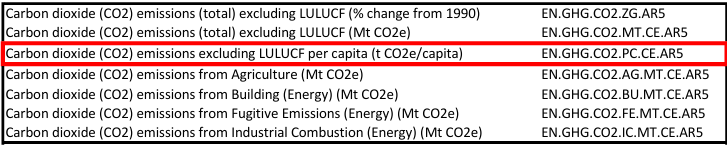

In [10]:
target_like_features = df22.filter(like="CO2").columns.to_list() + [
    "EN.GHG.TOT.ZG.AR5",
    "EN.GHG.ALL.MT.CE.AR5",
    "EN.GHG.ALL.PC.CE.AR5",
    "EN.GHG.ALL.LU.MT.CE.AR5",
]
y = df22["EN.GHG.CO2.PC.CE.AR5"].dropna()
X = df22.drop(columns=target_like_features, errors="ignore").loc[y.index]
X.shape, y.shape

((251, 1047), (251,))

Здесь мы заодно удалили из рассмотрения объекты, для которых пропущен таргет.

### 1.2 Выбор признаков

Итак, мы имеем около **1000 признаков** для более чем **250 объектов**. Ситуация не из простых...

Для начала, проанализируем как обстоят дела с пропусками. Посчитаем их и отобразим при помощи гистограммы:

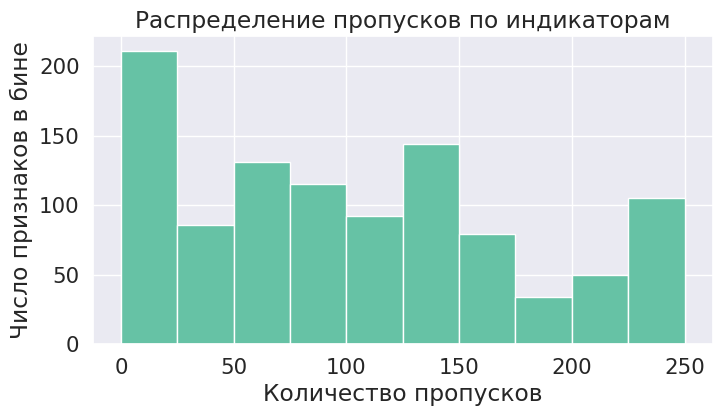

In [11]:
nans = X.isna().sum()

plt.figure(figsize=(8, 4))
nans.hist()
plt.xlabel("Количество пропусков")
plt.ylabel("Число признаков в бине")
plt.title("Распределение пропусков по индикаторам");

Сразу отсеем все признаки, в которых число пропущенных значений превышает некоторый порог.

In [12]:
threshold = 50  # порог
X.drop(columns=X.columns[nans > threshold], inplace=True)
print(
    f"Осталось {len(X.columns)} признаков с менее чем {threshold} пропущенными значениями"
)

Осталось 301 признаков с менее чем 50 пропущенными значениями


Разделим выборку на обучающую и тестовую части:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=random_state
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 301), (101, 301), (150,), (101,))

### 1.3 Стандартизация
Мы хотим, чтобы коэффициенты линейной регрессии имели единый масштаб и размерность. Отнормируем признаки:

In [14]:
# Инициализируем класс
scaler = StandardScaler().set_output(transform="pandas")

# Преобразуем обучающую и валидационную выборки
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 1.4 Заполняем пропуски
Одним из способов обработки пропущенных значений является их замена на определённую константу. Наиболее часто в её роли выступает медиана признака.

**❗Важно❗** Медианы признаков должны быть посчитанны **только** на обучающей выборке, но **никак не отдельно по каждой или целиком по всей**.

Для подобных преобразований можно воспользоваться трансформером [`sklearn.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html):

In [16]:
imputer = SimpleImputer(strategy="median").set_output(transform="pandas")

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Проверим, что всё преобразовалось корректно, и пропусков в данных нет:

In [17]:
np.any(X_train.isna()), np.any(X_test.isna()),

(False, False)

### 1.5 Отбираем признаки


Из оставшихся признаков имеет смысл отобрать те, по которым таргет можно считать более или менее линейным. Для этого построим линейную регрессию отдельно для каждой фичи и вычислим коэффициент детерминации $R^2$:

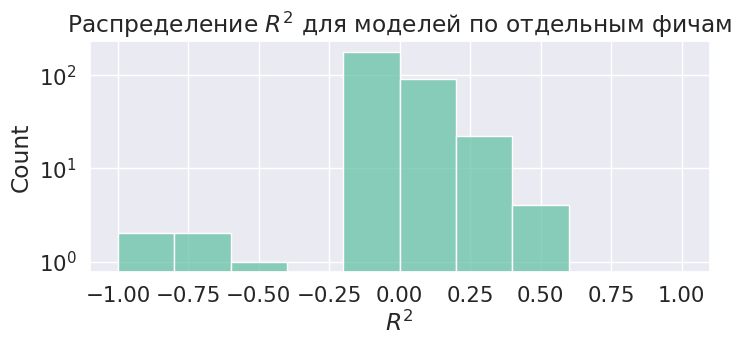

In [19]:
# Сюда будем записывать R2
r2 = pd.Series(index=X_train.columns, dtype=float)

for feature in X_train.columns:

    model_1d = LinearRegression()
    model_1d.fit(X_train[feature].values.reshape(-1, 1), y_train)
    r2[feature] = r2_score(
        y_test, model_1d.predict(X_test[feature].values.reshape(-1, 1))
    )

plt.figure(figsize=(8, 3))
sns.histplot(r2, bins=10, binrange=(-1, 1))
plt.title("Распределение $R^2$ для моделей по отдельным фичам")
plt.xlabel("$R^2$")
plt.yscale("log")

**Вывод:** есть признаки c $R^2 < 0$.

Попробуем оставить только те, для которых линейная регрессия даёт $ R^2 $ выше некоторого порога:

In [20]:
# Порог установим с небольшим запасом
threshold = 0.1
features_to_exclude = X.columns[r2 < threshold]

X_train.drop(columns=features_to_exclude, inplace=True, errors="ignore")
X_test.drop(columns=features_to_exclude, inplace=True, errors="ignore")
X_train.shape, X_test.shape

((150, 68), (101, 68))

Мы сократили число признаков примерно в 10 раз, без какого-либо отбора вручную!

## 2. Что не так с методом наименьших квадратов?

Теперь попробуем аппроксимировать данные **линейной регрессией**. Обучим модель, посчитаем коэффициент детерминации [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) и [RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html) на тесте:

In [21]:
# Инициализация модели и обучение
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = linear_model.predict(X_test)

print(
    f"R2: {r2_score(y_test, y_pred):.2f} \nRMSE: {root_mean_squared_error(y_test, y_pred):.2f}"
)

R2: -3.70 
RMSE: 9.45


**Вывод**: полученный $R^2$ говорит о том, что такая аппроксимация работает хуже, чем простое предсказание средним `y_pred = y_train.mean()`.

Действительно:

In [22]:
# Предсказание средним значением таргета на обучающей выборке
y_pred_mean = y_train.mean() * np.ones_like(y_test)

print(
    f"R2: {r2_score(y_test, y_pred_mean):.2f} \nRMSE: {root_mean_squared_error(y_test, y_pred_mean):.2f}"
)

R2: -0.07 
RMSE: 4.50


Изобразим на одном графике распределение ошибок на тесте, а также отклонение тестовых объектов от `y_train_mean`.

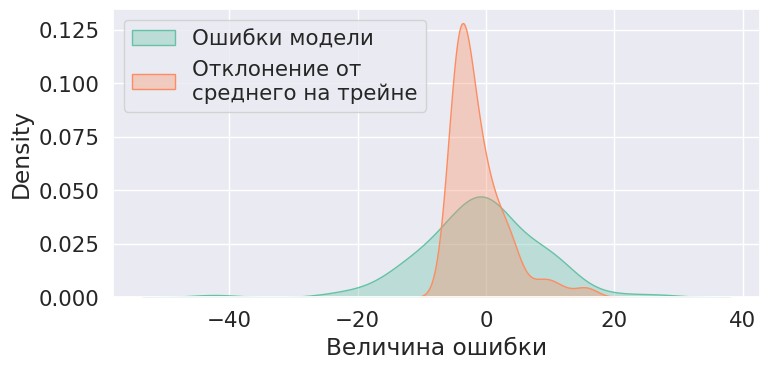

In [ ]:
plt.figure(figsize=(8, 4), tight_layout=True)

err = y_test.values - y_pred
std = y_test.values - y_pred_mean

sns.kdeplot(err, fill=True, alpha=0.35, label="Ошибки модели")
sns.kdeplot(std, fill=True, alpha=0.35, label="Отклонение от\nсреднего на трейне")
plt.legend()
plt.xlabel("Величина ошибки");

**Вывод:** действительно, такая модель менее информативна, чем простое усреднение.

Итак, наше желание обойтись малой кровью упирается в низкий коэффициент детерминации. Перечислим факторы, которые могли на это повлиять:

1.   Функциональная зависимость между фичами и таргетом могла оказаться нелинейной. Это &mdash; наиболее очевидное предположение, однако, даже в этом случае вполне естесственно хотеть выявить линейную взаимосвязь таргета и определённых факторов.
2.   Зависимость всё же близка к линейной, но признаки оказались "псевдо-зависимы", или **мультиколлинеарны**.
3. Зависимость нелинейна, а признаки мультиколлинеарны.

Будем надеяться на пункт 2 и исследуем, есть ли зависимости между отдельными признаками.

## 3. Как распознать мультиколлинеарность?

Быстрый ответ такой: если признаков **очень много**, скорее всего, они **мультиколлинеарны**. Но давайте копнём поглубже.

### 3.1 Число обусловленности

Число обусловленности (condition number) матрицы — это мера того, насколько чувствительно решение системы линейных уравнений $X\theta = y$ к изменениям в $y$ или в самой матрице $X$. Чем выше число обусловленности, тем больше может увеличиваться ошибка в решении при небольших изменениях в признаках и таргете.

> *Для прямоугольной матрицы $X$ оно равно корню из отношения наибольшего и наименьшего собственных числел матрицы $X^TX$:*
$$
    κ(X) = \sqrt{\frac{\lambda_1}{\lambda_n}}
$$


Найдём число обусловленности нашей тренировочной матрицы:

In [ ]:
np.linalg.cond(X_train)

2.0233202454319468e+16

**Вывод:**
число обусловленности огромно, простая линейная модель будет крайне чувствительна к шуму в данных.

### 3.1 Матрица корреляций

Построение матрицы корреляций позволяет количественно оценить вклад парных зависимостей между признаками.

> Коэффициент корреляции &mdash; мера того, насколько хорошо точки ложатся на прямую: \\
$$
    r_{pearson}(X, Y) = \frac{\sum_{i=1}^n(X_i - \overline{X})(Y_i - \overline{Y})}{\sqrt{\sum_{i=1}^n(X_i - \overline{X})^2}\sqrt{\sum_{i=1}^n(Y_i - \overline{Y})^2}} = \frac{cov(X, Y)}{S_X \cdot S_Y},
$$
где
*   $X$ и $Y$ - векторы значений двух признаков длины $n$,
*   $S$ - выборочные среднеквадратичные отклонения,
*   $cov$ - выборочная ковариация,
*   $\overline{X}$ и $\overline{Y}$ - выборочные средние $X$ и $Y$.

Чем ближе $r_{pearson}$ к $\pm1$, тем выше степень линейной зависимости между признаками.
На графике это выглядит так:

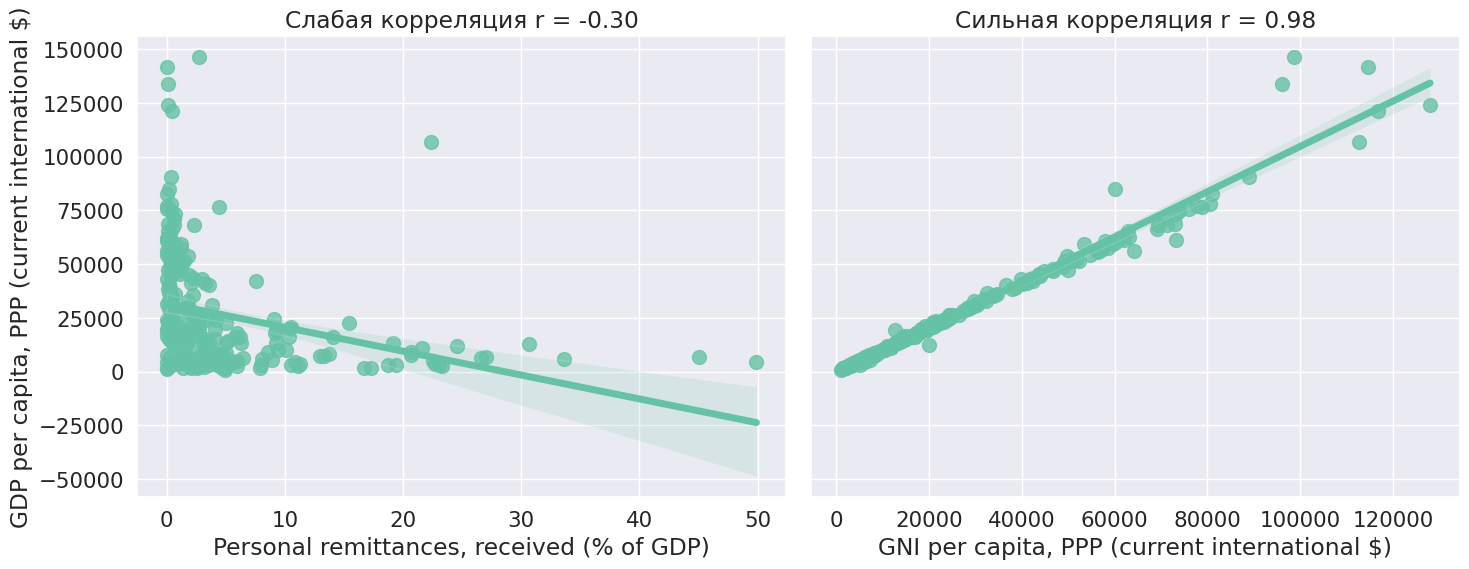

In [ ]:
fig, (ax_low_corr, ax_high_corr) = plt.subplots(
    1, 2, figsize=(15, 6), sharey=True, tight_layout=True
)

# Выберем некоторый индикатор для сравнения
compared = "NY.GDP.PCAP.PP.CD"

# Два других индикатора
high_corr = "NY.GNP.PCAP.PP.CD"  # Сильно коррелирует с первым
low_corr = "BX.TRF.PWKR.DT.GD.ZS"  # Слабо коррелирует с первым

# Объединим их в один массив и удалим выбросы
sub_X = X[[compared, high_corr, low_corr]].dropna()

# Отображаем зависимость между значениями двух слабо коррелирующих индикаторов
sns.regplot(
    x=sub_X[low_corr],
    y=sub_X[compared],
    scatter_kws={"s": 100},
    line_kws={"lw": 5},
    ax=ax_low_corr,
)

# Настраиваем подписи
ax_low_corr.set_ylabel(indicators[compared])
ax_low_corr.set_xlabel(indicators[low_corr])

# Вычисляем коэффициент корреляции для слабо коррелирующих индикаторов
weak_corr = np.corrcoef(sub_X[low_corr], sub_X[compared])[0, 1]
ax_low_corr.set_title(f"Слабая корреляция r = {weak_corr:.2f}")  # Заголовок графика

# Отображаем зависимость между значениями двух сильно коррелирующих индикаторов
sns.regplot(
    x=sub_X[high_corr],
    y=sub_X[compared],
    scatter_kws={"s": 100},
    line_kws={"lw": 5},
    ax=ax_high_corr,
)

# Настраиваем подписи
ax_high_corr.set_ylabel("")
ax_high_corr.set_xlabel(indicators[high_corr])

# Вычисляем коэффициент корреляции для сильно коррелирующих индикаторов
strong_corr = np.corrcoef(sub_X[high_corr], sub_X[compared])[0, 1]

plt.title(f"Сильная корреляция r = {strong_corr:.2f}");

Удобнее всего отобразить коэффициенты корреляции в виде матрицы:

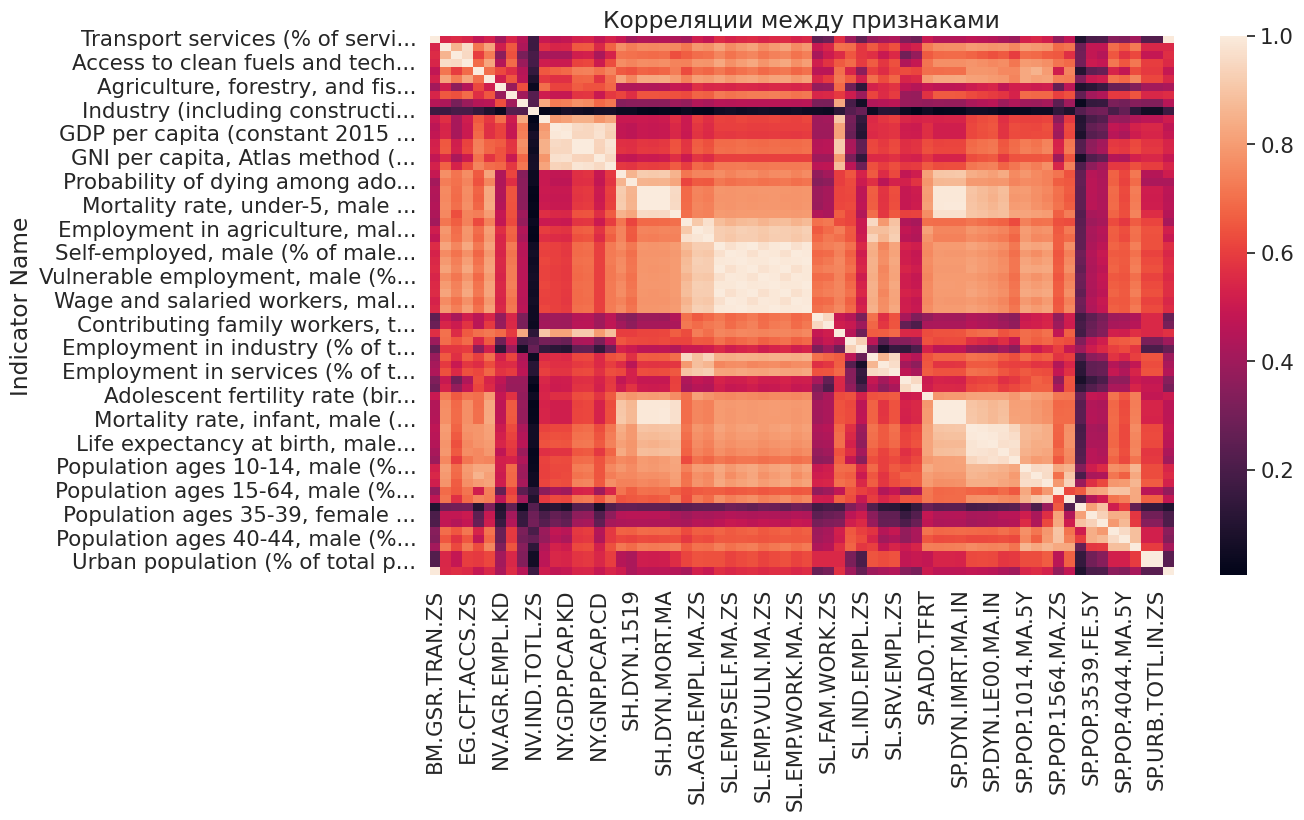

In [ ]:
def cut_str(s: str, max_length: int = 30) -> str:
    """Обрезает строку `s`, если число символов в ней превосходит `max_length`"""

    return s[:max_length] + "..." if len(s) > max_length else s


# Считаем корреляции между индикаторами и визуализируем что получилось
corr_matrix = (
    X_train.corr().abs()
)  # Знак коэффициентов корреляции нам будет, скорее, мешать

# Переименуем индексы массива в полные названия
corr_matrix.index = indicators[corr_matrix.index].apply(cut_str)

# Визуализация
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix).set(title="Корреляции между признаками");

**Вывод:** наблюдаем много светлых пикселей &mdash; высоких коэффициентов корреляции (исключая главную диагональ). Это неудивительно, поскольку многие индикаторы отражают близкие по своей сути вещи, но выражаются в разных метриках или, например, собраны по разным группам населения.

  ### 3.3 Коэффициент инфляции дисперсии (VIF)

Другим способом продемонстрировать мультиколлинеарность является коэффициент VIF ([Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor#cite_note-1)). Будем строить линейную модель, используя в качестве целевой переменной один из признаков, а остальные &mdash; как независимые переменные. Таким образом, мы проверяем, существует ли между признаками линейная зависимость. Метрика определяется следующим образом:

$$
    VIF_i = \frac{1}{1 - R_i^2},
$$
где $R_i^2$ - это значение $R^2$ для линейной регрессии $i$-го признака по остальным.

Считается, что
*  $VIF = 1$ &mdash; переменные не коррелируют;
*  $1 < VIF < 10$ &mdash; переменные коррелируют частично
*  $VIF > 10$ &mdash; переменные коррелируют очень сильно.

&#x2753; **Вопрос (в бот)** &#x2753;

> Чему равны соответствующие $R^2$ ?

<details>
  <summary> Кликни для показа ответа </summary>
  
>&#x1F4A1;
1. $R^2 = 0$
2. $0 < R^2 < 0.9$;
3. $R^2 > 0.9$

</details><br/>

Реализуем функцию подсчёта VIF для одного признака в выборке:

In [ ]:
def calculate_single_vif(X_train: pd.DataFrame, feature: str):
    """Вычисляет коэффициент инфляции дисперсии (VIF) для отдельного признака.

    Args:
        X_train (pd.DataFrame): обучающая выборка
        feature (str): название признака

    Returns:
        float: значение VIF для указанного объекта.
    """
    # Один из признаков перемещаем в отдельную переменную
    X_VIF, y_VIF = X_train.drop(columns=feature), X_train[feature]

    # Делим выборки на трейн и тест
    X_train_VIF, X_test_VIF, y_train_VIF, y_test_VIF = train_test_split(
        X_VIF, y_VIF, test_size=0.5, random_state=random_state
    )

    # Создание модели, обучение и подсчёт метрики
    model_VIF = LinearRegression()
    model_VIF.fit(X_train_VIF, y_train_VIF)
    r2 = r2_score(y_test_VIF, model_VIF.predict(X_test_VIF))

    return np.inf if r2 == 1 else 1 / (1 - r2)

Посчитаем VIF для всех имеющихся индикаторов и отобразим результаты на гистограмме:

In [ ]:
VIFs = []

for feature in X_train.columns:
    VIFs.append(calculate_single_vif(X_train, feature))

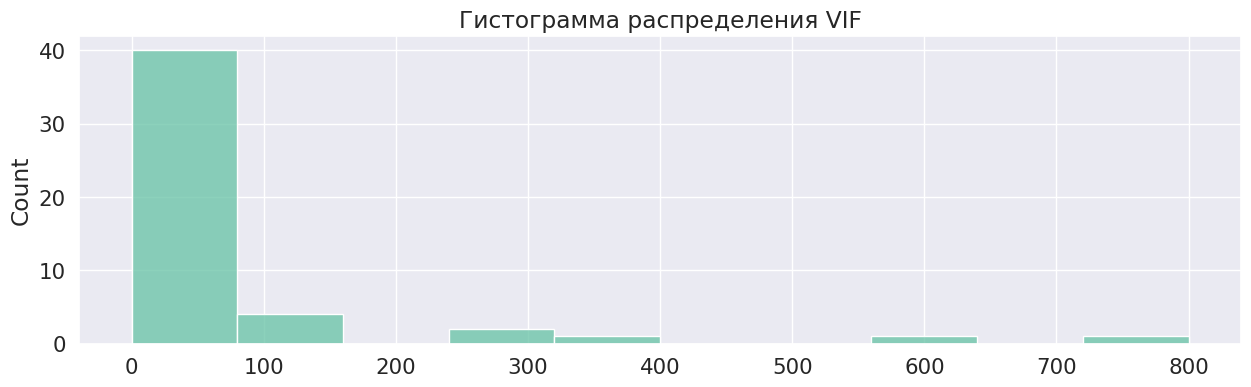

In [ ]:
plt.figure(figsize=(10, 4))

sns.histplot(VIFs, bins=10, binrange=(0, 800))
plt.title("Гистограмма распределения VIF");

**Вывод:** присутствуют очень большие VIF, что вновь указывает на наличие мультиколлинеарности.

&#x2753; **Вопрос** &#x2753;

> В чём преимущество такой проверки перед подсчётом матрицы корреляций?

<details>
  <summary> Кликни для показа ответа </summary>
  
> VIF учитывает не только парные зависимости, но и комбинации из нескольких фичей.

</details><br/>

## 4. Как бороться с мультиколлинеарностью?

На практике чаще всего используют следующие методы:

1.   Регуляризация
2.   Преобразование признакового пространства
3.   Отбор признаков.

К линейным моделями эффективнее и проще применять *регуляризацию*, которую далее и рассмотрим.

### 4.1 Регуляризация

>####  Краткое напоминание
Метод подразумевает под собой некую модификацию линейной модели, которая добавляет к функционалу ошибки штраф за слишком большие значения коэффициентов. Это помогает справиться с мультиколлинеарностью, стабилизируя модель и улучшая её обобщающую способность. В задаче линейной регрессии наиболее часто используют модели
 [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) и [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).
* **Ridge** &mdash; это модель линейной регрессии с $L_2$-регуляризацией, которая минимизирует функционал
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert^2_2 → \min_\theta
$$
Здесь $Y \in \mathbb{R}^{n}$ &mdash; истинные значения целевой переменной, $X \in \mathbb{R}^{n\times d}$ &mdash; матрица "объект-признак", ${\theta} \in \mathbb{R}^{d}$ &mdash; коэффициенты модели. Параметр регуляризации $\alpha \geq 0$ управляет силой штрафа. Является **гиперпараметром**, т.е. задаётся пользователем.
* **Lasso** &mdash; модель линейной регрессии с $L_1$-регуляризацией. Минимизирует функционал\
$$
    \lVert Y - X \theta\rVert^2_2 + \alpha  \lVert\theta\rVert_1 → \min_\theta
$$
* **ElasticNet** &mdash; компромисс между двумя предыдущими. Минимизирует функционал\
$$
    \lVert Y - X\theta\rVert^2_2 + \alpha_1  \lVert\theta\rVert_1 + \alpha_2  \lVert\theta\rVert^2_2 → \min_\theta
$$

Теперь рассмотрим все варианты регуляризации и поймем, как значения гиперпараметров влияют на результат.

#### Применяем методы Ridge и Lasso

Применение линейных моделей с регуляризацией ничем не отличается от линейной регрессии, за исключением лишь того, что нужно задать гиперпараметр $\alpha$. Рассмотрим сразу много различных "альф", чтобы понять, при какой величине достигается наилучшее качество. Набросать соответствующий скрипт также быстрее всего при помощи ИИ, если аккуратно расписать, что мы от него хотим.

In [ ]:
# Создаём сетку параметров регуляризации.
# Здесь удобнее работать с логарифмической шкалой
alphas = {"lasso": np.logspace(-5, 2, 500), "ridge": np.logspace(-8, 7, 500)}

# Создаём списки, куда будем записывать метрику качества
r2_train = {"lasso": [], "ridge": []}
r2_test = {"lasso": [], "ridge": []}

for model_name, model in {"lasso": Lasso(), "ridge": Ridge()}.items():

    for alpha in alphas[model_name]:

        # Устанавливаем очередное альфа и обучаем
        model.set_params(alpha=alpha)
        model.fit(X_train, y_train)

        # Считаем метрику и добавляем в списки
        r2_test[model_name].append(r2_score(y_test, model.predict(X_test)))
        r2_train[model_name].append(r2_score(y_train, model.predict(X_train)))

Сохраняем наилучшие гиперпараметры:

In [ ]:
best_alpha_lasso = alphas["lasso"][np.argmax(r2_test["lasso"])]
best_alpha_ridge = alphas["ridge"][np.argmax(r2_test["ridge"])]
print(
    f'Для Lasso: R2_best = {np.max(r2_test["lasso"]):.2f} (test) при alpha = {best_alpha_lasso:.2f}\nДля Ridge: R2_best = {np.max(r2_test["ridge"]):.2f} (test) при alpha = {best_alpha_ridge:.2f}'
)

Для Lasso: R2_best = 0.54 (test) при alpha = 0.27
Для Ridge: R2_best = 0.59 (test) при alpha = 125.95


Визуализация:

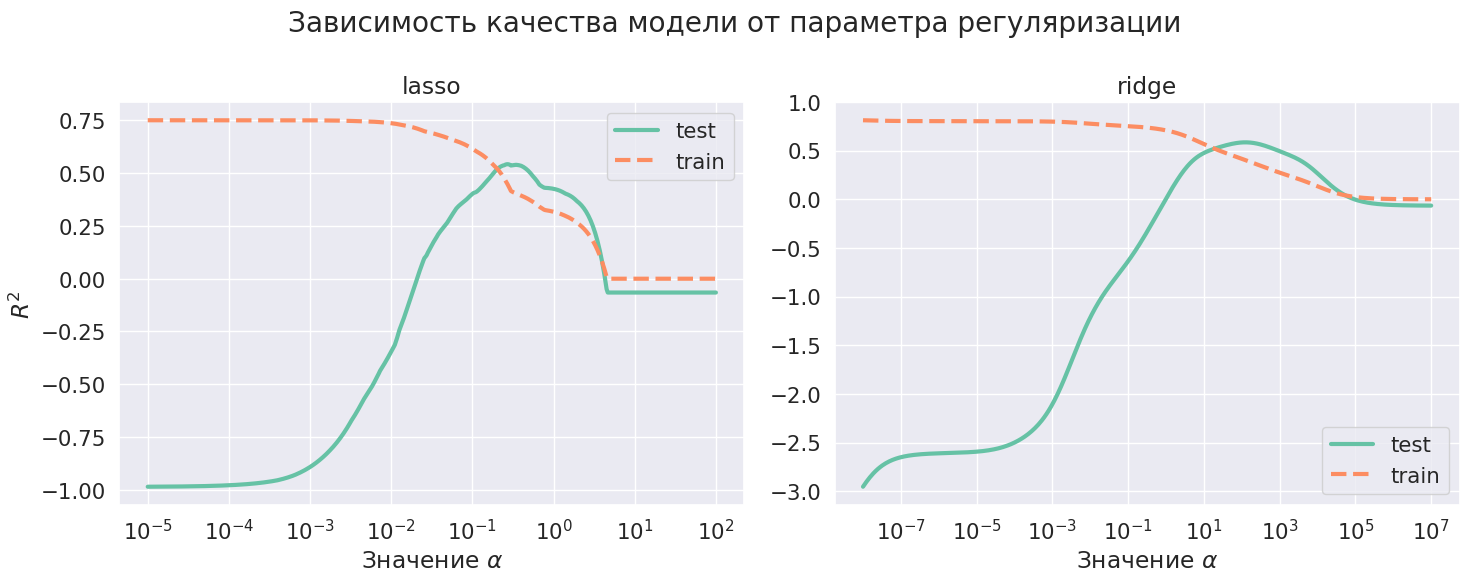

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)

for ax, model_name in zip(axes, alphas.keys()):

    ax.plot(alphas[model_name], r2_test[model_name], label="test", lw=3, ls="-")
    ax.plot(alphas[model_name], r2_train[model_name], label="train", lw=3, ls="--")
    ax.set_xscale("log")  # Логарифмический масштаб
    ax.set_xlabel("Значение $\\alpha$")
    ax.set_title(model_name)
    ax.legend()

axes[0].set_ylabel("$R^2$")
fig.suptitle("Зависимость качества модели от параметра регуляризации");

**Выводы**

1.  На графиках наблюдается общая асимптотика при $\alpha → +∞$: штрафы становятся настолько большими, что все коэффициенты становятся равны или стремятся к нулю, и предсказание сводится к среднему таргету на тренировочной выборке (когда $R^2 \approx 0$).

2.  Заметна разница в "гладкости" функций. Lasso-регрессия резко обнуляет коэффициенты один за другим, что приводит к скачкообразным изменениям метрики. Ridge-регрессия всегда плавно уменьшает коэффициенты модели. В отличие от неё, Ridge-регрессия плавно уменьшает коэффициенты, обеспечивая более плавное изменение $R^2$.

3. Регуляризация эффективно борется с переобучением: метрика на тестовой выборке улучшается, в то время как на тренировочной — ухудшается.

#### Применяем ElasticNet

Так как это комбинация двух предыдущих моделей, то и гиперпараметров необходимо задавать два: `alpha`, `l1_ratio`. Связь между ними и $\alpha_1, \alpha_2$, которые мы вводили ранее, выглядит так:

$$
\verb|alpha| = \alpha_1 + 2\alpha_2
\\
\verb|l1_ratio| = \frac{\alpha_1}{\alpha_1 + 2\alpha_2}
\\
\alpha_1 = \verb|alpha| \cdot \verb|l1_ratio|
\\
\alpha_2 = \frac{1}{2} \verb|alpha| \cdot (1 - \verb|l1_ratio|)
$$

Аналогично, будем обучать модели с разными `alpha`, `l1_ratio`, чтобы увидеть наилучшую комбинацию.

In [ ]:
# Задаём сетки гиперпараметров
alphas = np.logspace(-2, 2, 50)
l1_ratios = np.linspace(0, 1.0, 50)

# Метрика качества - функция двух переменных alpha и l1_ratio,
# поэтому создаём пустой двумерный массив
r2_elastic = np.empty((len(l1_ratios), len(alphas)))

# Итерируемся по всем комбинациям alpha и l1_ratio
for alpha_idx, alpha in enumerate(alphas):
    for l1r_idx, l1_ratio in enumerate(l1_ratios):

        # Создаём модель ElasticNet
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state)

        # Обучаем
        model.fit(X_train, y_train)

        # Делаем предсказание
        y_pred = model.predict(X_test)

        # Считаем метрику и сохраненяем в массив
        r2_elastic[l1r_idx, alpha_idx] = r2_score(y_test, y_pred)

Сохраняем наилучшие гиперпараметры:

In [ ]:
arg = np.argmax(r2_elastic)

best_elastic = {
    "alpha": alphas[arg % alphas.size],
    "l1_ratio": l1_ratios[arg // l1_ratios.size],
}

print(f"R2_best = {np.max(r2_elastic):.2f} при {best_elastic}")

R2_best = 0.58 при {'alpha': 0.7543120063354615, 'l1_ratio': 0.0}


**Вывод:** в нашем случае комбинация из двух видов регуляризации не даёт преимущества по метрике $R^2$.

#### Визуализируем коэффициенты

Фиксируем оптимальные параметры, которые мы нашли и заново обучим МНК, Ridge и Lasso:

In [ ]:
models = {
    "Linear": LinearRegression().fit(X_train, y_train),
    "Ridge": Ridge(alpha=best_alpha_ridge).fit(X_train, y_train),
    "Lasso": Lasso(alpha=best_alpha_lasso).fit(X_train, y_train),
}

# Коэффициенты моделей сохраним в виде DataFrame
coef_df = pd.DataFrame(
    {name: model.coef_ for name, model in models.items()},
    index=indicators[X_train.columns],
)

Посчитаем, сколько ненулевых коэффициентов осталось в модели Lasso-регрессии:

In [ ]:
(coef_df["Lasso"] != 0).sum()

17

Визуализируем их вместе с аналогичными коэффициентами двух других моделей:

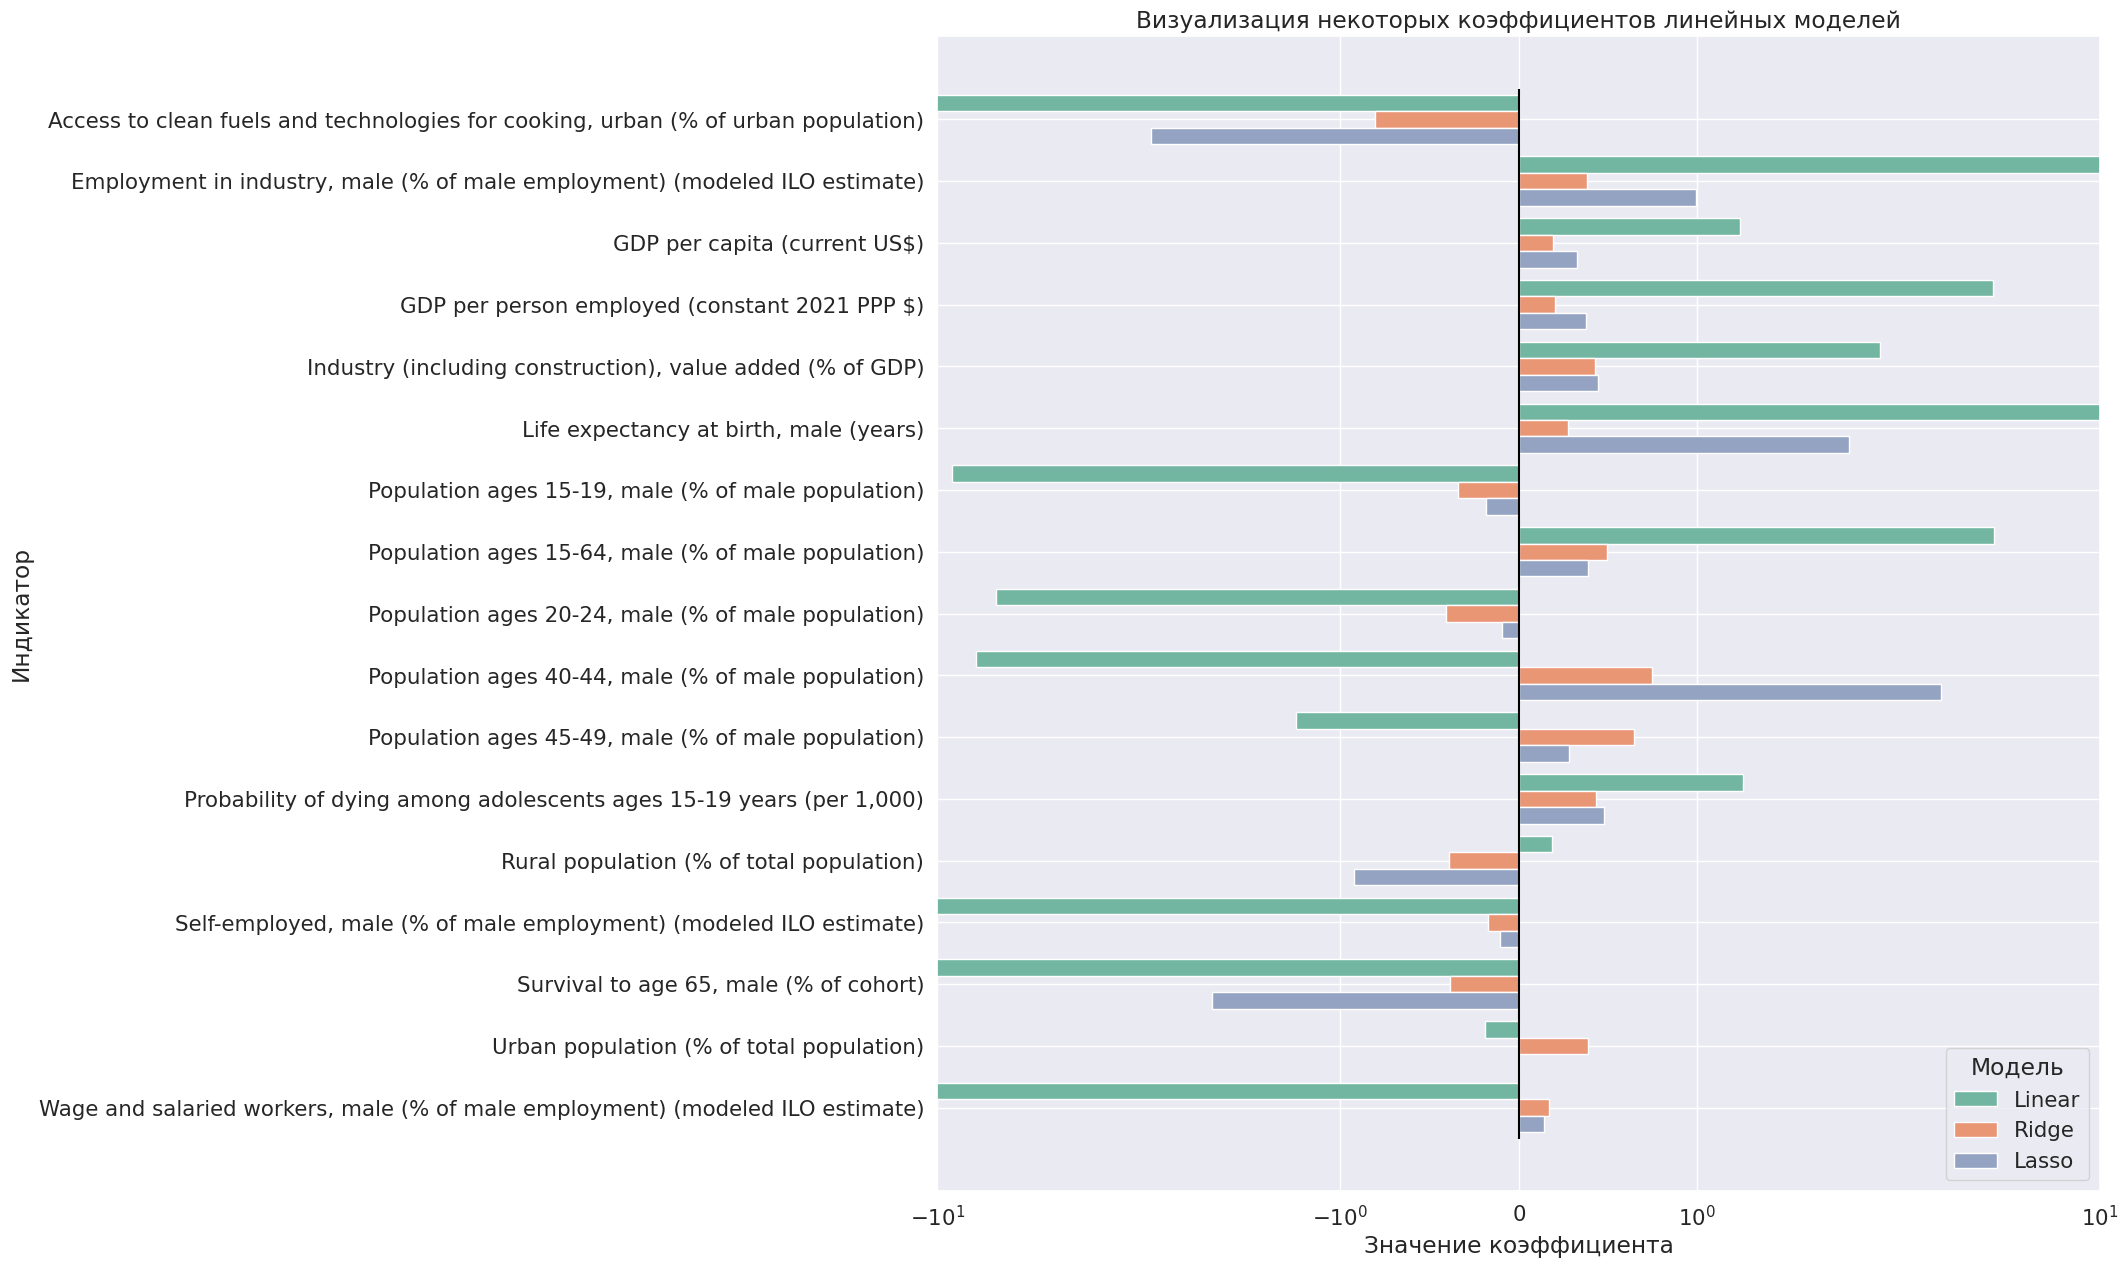

In [ ]:
# Выбираем признаки с ненулевыми коэффициентами у Lasso
top_features = coef_df["Lasso"][(coef_df["Lasso"] != 0)].index

# Вытаскиваем аналогичные коэффициенты у МНК и Ridge
top_coef_df = coef_df.loc[top_features].reset_index(names="Индикатор")

# Сортируем по алфавиту
top_coef_df.sort_values(by="Индикатор", inplace=True)

# Преобразуем таблицу в "длинный формат" для удобной визуализации
top_coef_df = top_coef_df.melt(
    id_vars="Индикатор", var_name="Модель", value_name="Значение коэффициента"
)

# Визуализация
plt.figure(figsize=(15, 15))
sns.barplot(
    data=top_coef_df, y="Индикатор", x="Значение коэффициента", hue="Модель", orient="h"
)
plt.grid("both")
plt.xscale("symlog")  # Логарифмический масштаб с учётом знака
plt.xlim((-10, 10))
plt.vlines(0, *plt.gca().get_ylim(), color="black")
plt.title("Визуализация некоторых коэффициентов линейных моделей");

**Выводы о влиянии регуляризации на коэффициенты**

1.  Регуляризация уменьшает масштаб коэффициентов: у простой линейной модели они значительно больше, чем у моделей с регуляризацией.
2.  Ridge-регрессия равномерно снижает значения всех коэффициентов. В то же время Lasso выделяет наиболее значимые признаки, присваивая им относительно большие коэффициенты, а остальные зануляет.
3.  В некоторых случаях под воздействием регуляризации может изменяться знак коэффициентов.

&#x2753; **Вопрос** &#x2753;

> Почему не всегда стоит стремиться к уменьшению всех коэффициентов в модели? Как это может повлиять на интерпретацию результатов?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Коэффициенты должны иметь единый масштаб, однако вполне естественно, когда перед наиболее значимыми признаками стоят б**о**льшие коэффициенты, чем перед второстепенными. Усиление регуляризации повлечёт "выравнивание в правах" главных и вторичных признаков, что негативно скажется на интерпретации.

</details><br/>

## 5. Интерпретация результатов

Все построенные модели демонстрируют невысокую предсказательную силу (низкий $R^2$). Для получения более надёжных оценок рекомендуется проводить обучение при различных разбиениях на обучающую и валидационную выборки с последующим усреднением метрик и коэффициентов регрессии (т.н. кросс-валидация моделей). Тем не менее, попробуем извлечь полезную информацию из имеющихся результатов.

1.  Среди факторов, значимо связанных с выбросами $\text{CO}_2$, закономерно выделяются:
    *   объём промышленного производства и общая занятость в индустрии,
    *   ВВП на душу населения и на одного работающего гражданина,
    *   продолжительность жизни и доля людей, доживающих до 65 лет.

2.  Обе модели (Ridge и Lasso) согласны в том, что целевая переменная имеет определённую связь с показателем смертности среди подростков 15-19 лет (`Probability of dying among adolescents ages 15-19 years`).

3.  Ridge-регрессия также указывает на то, что высокая доля городского населения положительно коррелирует с объёмом выбросов $\text{CO}_2$. В то же время высокая доля сельского населения оказывает обратный эффект.

4.  Примечательно, что среди значимых признаков присутствует множество показателей, связанных с численностью населения. При этом интегральные характеристики (например, общая численность) менее важны, чем данные по отдельным категориям: разные возрастные группы и пол вносят различный вклад, иногда даже с противоположным знаком.

Здесь мы не будем углубляться в анализ остальных признаков, так как корректный подход требует применения кросс-валидации.

## Заключение

Мы рассмотрели, как мультиколлинеарность проявляется в реальных данных, и как регуляризация помогает сохранить ключевое преимущество простой линейной модели — её интерпретируемость. Более сложные алгоритмы машинного обучения, такие как нейронные сети, случайный лес и градиентный бустинг, безусловно, обладают своими преимуществами, однако интерпретация их структуры часто оказывается сложной задачей, а в некоторых случаях и вовсе невозможной.